# Bird Classifier! #

I am trying to find a fine-tuned Bird Classifier model that can eventually identify what species the bird belongs to based on the given picture. Next, I'll prepare the data set and then train them with the Resnet model. In the process of training, I will constantly adjust the learning rate so that it can converge quickly in the early stage and converge slowly in the later stage.


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
checkpoints = '/kaggle/working/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

## Getting the bird Data
Is pretty easy, we can just use the built in dataset functionality. This time we might use some data augmentation.

RandomCrop(128, padding=8) - This will make the network sees slightly shifted around every time so it is harder to overfit to specific pixels in specific places. This forces the network to learn more robust filters and reduces overfitting.

RandomHorizontalFlip() - This means half the time we will flip the image horizontally. Same basically as above, the network sees shifted versions of the data so it's harder to overfit.

In [7]:
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.Resize(128),
        transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
    ])
    trainset = torchvision.datasets.ImageFolder(root='/kaggle/input/birds23sp/birds/train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='/kaggle/input/birds23sp/birds/test', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    
    classes = open("/kaggle/input/birds23sp/birds/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

In [8]:
print(data['test'].__dict__)

{'dataset': Dataset ImageFolder
    Number of datapoints: 10000
    Root location: /kaggle/input/birds23sp/birds/test
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           ), 'num_workers': 2, 'prefetch_factor': 2, 'pin_memory': False, 'pin_memory_device': '', 'timeout': 0, 'worker_init_fn': None, '_DataLoader__multiprocessing_context': None, '_dataset_kind': 0, 'batch_size': 1, 'drop_last': False, 'sampler': <torch.utils.data.sampler.SequentialSampler object at 0x78bebc2b4130>, 'batch_sampler': <torch.utils.data.sampler.BatchSampler object at 0x78bebc2b41c0>, 'generator': None, 'collate_fn': <function default_collate at 0x78bec8519b40>, 'persistent_workers': False, '_DataLoader__initialized': True, '_IterableDataset_len_called': None, '_iterator': None}


### Visualizing Some Data ###

torch.Size([16, 3, 128, 128])


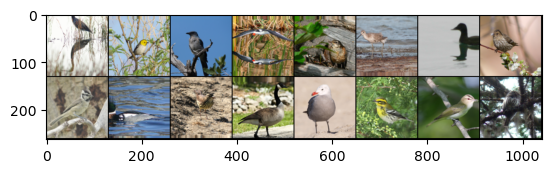

Labels:Tricolored Heron, Hermit Warbler, Mexican Jay, Black Skimmer, American Robin (Juvenile),    Willet, White-winged Scoter (Female/juvenile), Pine Siskin, Bridled Titmouse, Red-breasted Merganser (Breeding male), Northern Waterthrush, Canada Goose, Heermann's Gull (Adult), Townsend's Warbler, Red-eyed Vireo, Northern Pygmy-Owl


In [9]:
dataiter = iter(data['train'])
images, labels = next(dataiter)
images = images[:16]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(16)))

### Training Code

In [10]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=100, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)


    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                    print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

In [11]:
def accuracy(net, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

def smooth(x, size):
    return np.convolve(x, np.ones(size)/size, mode='valid')

## Train the Resnet50

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0


[0,   100] loss: 5.284
[0,   200] loss: 3.363
[0,   300] loss: 2.673
[1,   100] loss: 2.112
[1,   200] loss: 2.004
[1,   300] loss: 1.873
[2,   100] loss: 1.546
[2,   200] loss: 1.539
[2,   300] loss: 1.512
[3,   100] loss: 1.280
[3,   200] loss: 1.278
[3,   300] loss: 1.287
[4,   100] loss: 1.094
[4,   200] loss: 1.109
[4,   300] loss: 1.139


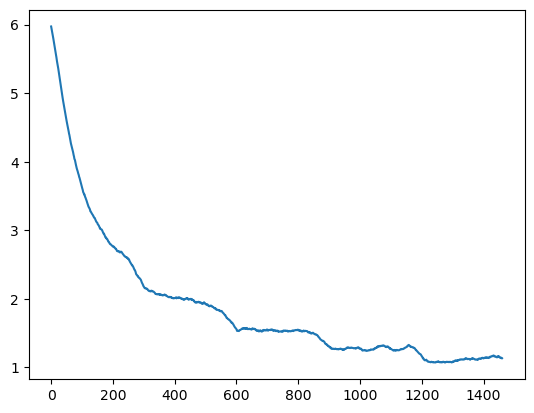

In [12]:
resnet = torch.hub.load('pytorch/vision:v0.13.0', 'resnet50', pretrained=True)
resnet.fc = nn.Linear(2048, 555) # This will reinitialize the layer as well

losses = train(resnet, data['train'], epochs=5, lr=.01, print_every=100, checkpoint_path=checkpoints)

plt.plot(smooth(losses,50))

# print("Training accuracy: %f" % accuracy(resnet, data['train']))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0


[5,   100] loss: 0.946
[5,   200] loss: 0.965
[5,   300] loss: 0.992
[6,   100] loss: 0.879
[6,   200] loss: 0.856
[6,   300] loss: 0.893
[7,   100] loss: 0.758
[7,   200] loss: 0.772
[7,   300] loss: 0.806
[8,   100] loss: 0.683
[8,   200] loss: 0.684
[8,   300] loss: 0.728
[9,   100] loss: 0.590
[9,   200] loss: 0.638
[9,   300] loss: 0.687


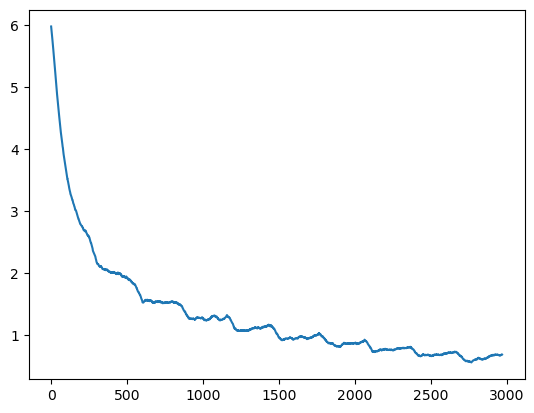

In [13]:
resnet = torch.hub.load('pytorch/vision:v0.13.0', 'resnet50', pretrained=True)
resnet.fc = nn.Linear(2048, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + 'checkpoint-5.pkl')
losses = train(resnet, data['train'], epochs=10, lr=.01, print_every=100, checkpoint_path=checkpoints, state=state)

plt.plot(smooth(losses,50))

#print("Training accuracy: %f" % accuracy(resnet, data['train']))

Use a learning rate of 0.001 starting from epoch 15.

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0


[10,   100] loss: 0.549
[10,   200] loss: 0.561
[10,   300] loss: 0.634
[11,   100] loss: 0.508
[11,   200] loss: 0.532
[11,   300] loss: 0.549
[12,   100] loss: 0.460
[12,   200] loss: 0.482
[12,   300] loss: 0.526
[13,   100] loss: 0.414
[13,   200] loss: 0.440
[13,   300] loss: 0.481
[14,   100] loss: 0.393
[14,   200] loss: 0.401
[14,   300] loss: 0.449


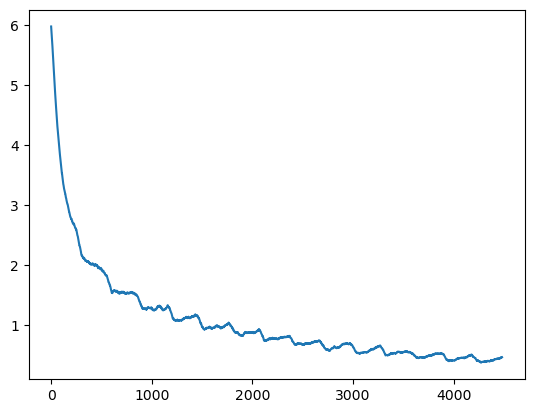

In [14]:
resnet = torch.hub.load('pytorch/vision:v0.13.0', 'resnet50', pretrained=True)
resnet.fc = nn.Linear(2048, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + 'checkpoint-10.pkl')
losses = train(resnet, data['train'], epochs=15, lr=.01, print_every=100, checkpoint_path=checkpoints, state=state)

plt.plot(smooth(losses,50))

#print("Training accuracy: %f" % accuracy(resnet, data['train']))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0


Learning rate: 0.010000
Learning rate: 0.001000
[15,   100] loss: 0.273
[15,   200] loss: 0.217
[15,   300] loss: 0.187
[16,   100] loss: 0.159
[16,   200] loss: 0.159
[16,   300] loss: 0.156
[17,   100] loss: 0.137
[17,   200] loss: 0.140
[17,   300] loss: 0.137


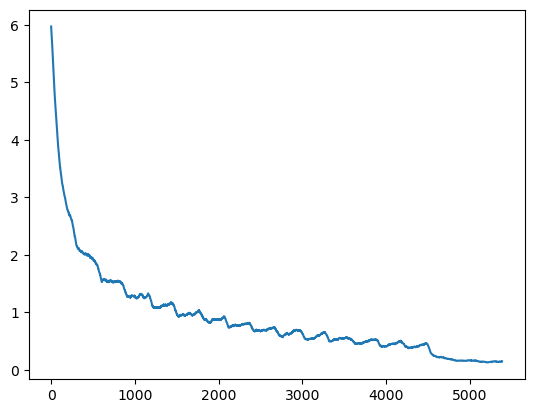

In [15]:
resnet = torch.hub.load('pytorch/vision:v0.13.0', 'resnet50', pretrained=True)
resnet.fc = nn.Linear(2048, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + 'checkpoint-15.pkl')
losses = train(resnet, data['train'], epochs=18, schedule={0:.01, 15:.001}, lr=.01, print_every=100, checkpoint_path=checkpoints, state=state)

plt.plot(smooth(losses,50))

#print("Training accuracy: %f" % accuracy(resnet, data['train']))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0


Learning rate: 0.010000
Learning rate: 0.001000
[18,   100] loss: 0.127
[18,   200] loss: 0.120
[18,   300] loss: 0.124
[19,   100] loss: 0.116
[19,   200] loss: 0.120
[19,   300] loss: 0.113
[20,   100] loss: 0.113
[20,   200] loss: 0.103
[20,   300] loss: 0.109


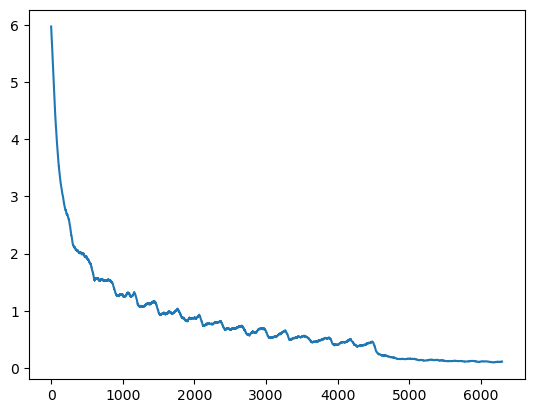

In [16]:
resnet = torch.hub.load('pytorch/vision:v0.13.0', 'resnet50', pretrained=True)
resnet.fc = nn.Linear(2048, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + 'checkpoint-18.pkl')
losses = train(resnet, data['train'], epochs=21, schedule={0:.01, 15:.001}, lr=.01, print_every=100, checkpoint_path=checkpoints, state=state)

plt.plot(smooth(losses,50))

#print("Training accuracy: %f" % accuracy(resnet, data['train']))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0


Learning rate: 0.010000
Learning rate: 0.001000
Learning rate: 0.000100
[21,   100] loss: 0.097
[21,   200] loss: 0.103
[21,   300] loss: 0.099
[22,   100] loss: 0.108
[22,   200] loss: 0.098
[22,   300] loss: 0.094
Training accuracy: 0.984881


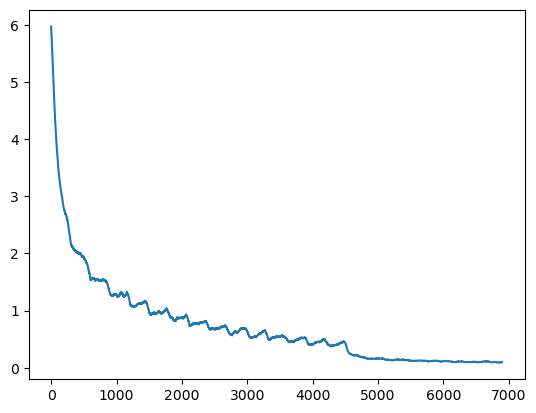

In [17]:
resnet = torch.hub.load('pytorch/vision:v0.13.0', 'resnet50', pretrained=True)
resnet.fc = nn.Linear(2048, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + 'checkpoint-21.pkl')
losses = train(resnet, data['train'], epochs=23, schedule={0:.01, 15:.001, 21:.0001}, lr=.01, print_every=100, checkpoint_path=checkpoints, state=state)

plt.plot(smooth(losses,50))

print("Training accuracy: %f" % accuracy(resnet, data['train']))

In [18]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%1000 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

In [19]:
# Load model from checkpoint
resnet = torch.hub.load('pytorch/vision:v0.13.0', 'resnet50', pretrained=True)
resnet.fc = nn.Linear(2048, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + 'checkpoint-23.pkl')
resnet.load_state_dict(state['net'])

predict(resnet, data['test'], checkpoints + "submission.csv")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
